
ERT resistivity inversion in 2D
================================



pyGIMLi (www.pygimli.org) and PyBERT (https://pypi.org/project/PyBERT/) are used to create mesh, perform forward modeling and inversion.

# 1) Import necessary dependencies and set environement
Normally do not need to modify the following 2 code "cells". <br/>
To run a cell, select with mouse and run by clicking [ ▸| Run ] in toolbar.<br/>
**RUN cells in the chronological order, do not skip any cell or this won't go...**<br/>

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {    return false;}

<IPython.core.display.Javascript object>

### If cell below produces error message --just run it twice !

In [3]:
import warnings
warnings.filterwarnings('ignore') # just to make it cleaner in the notebook
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
import pybert as pb
import pandas as pd
%matplotlib notebook
import matplotlib
from matplotlib import pyplot as plt

## Read the data file with apparent resisitivoty from TIGRE. <br/> 
## 1) upload your own ".dat" filefrom main menu:
<img src="Screenshot1.png" width="400"> 

## 2) Insert the file name below <br/>(in this example, tigre_20_01_2020.dat. Replace with yours)

In [4]:
# modify file name then RUN this cell:
tigre_file="tigre_20_01_2020.dat"

## 3) In the following code cells, the file is re-formatted in *unified* style, and then saved for further use.<br/> 
The new file will carry the same name as the original file plus "\_uni.dat" (i.e. file.dat -> file_uni.dat)<br/>
**It is advised to DOWNLOAD the newly formatted file to your own computer once it's converted.**<br/>
For this use main menu, tick file and then click Download:

<img src="Screenshot2.png" width="400">

Read header info, tretrieve nr. of electrodes, electrode spacing and total number of measurements of $\rho_a$ <br/>

In [5]:
# read header info :
with open(tigre_file, "r") as filin:
    headr=filin.read().splitlines()[0:6]
Nread=float(headr[3])
dx=float(headr[1])
filin.close()
# read data until end of file and strip the ending zeroes:
readings=[];
with open(tigre_file, "r") as filin:
    dada=filin.read().splitlines()[6:-1]
for line in dada:
    if line.strip("\n") != "0":
        readings.append(line.split())
filin.close()
readings=np.array(readings,dtype=np.float32)
first_spacing=readings[0,1]
Nel=2
for ri in readings:
    Nel=Nel+1 # Count Number of electrodes
    if ri[1] != first_spacing:
        break
#
display(pd.DataFrame(headr))
print("tot readings: ",Nread,"|| el. spacing dx= ",dx,"|| nr. of electrodes= ",Nel)

,0
0,w1 houghall: Line 1 / Spread 1
1,5
2,1
3,650
4,1
5,0


tot readings:  650.0 || el. spacing dx=  5.0 || nr. of electrodes=  64


In [6]:
# prepare sequence of electrode positions, PYBERT-unified style:
elpos=[]
for i in range(Nel):
    elpos.append([dx*i, 0, 0])
# Add synthetic topography: OR you can create a vector with the real topography and write it in elpos[i,2].
elpos=np.asarray(elpos)
for i in range(Nel):elpos[i,2]=elpos[i,2]+10.*np.exp(-i*dx/20.)

In [7]:
# Convert Wenner mid-point of 4x and "a" value to index of electrodes in array.
# Organise resistivity and corresponding electrode indexes, PYBERT-unified style, in array abmnr:
abmnr=[]
for ree in readings:
    p1=int(round((ree[0]-ree[1]/2.)/dx))+1
    p2=int(round((ree[0]+ree[1]/2.)/dx))+1
    c1=int(round((ree[0]-3*ree[1]/2.)/dx))+1
    c2=int(round((ree[0]+3*ree[1]/2.)/dx))+1
    abmnr.append([c1,c2,p1,p2,ree[2]])

In [8]:
# Put all together in one file in PYBERT-unified format:
filout=tigre_file[:-4]+"_uni"+".dat" # name of output file
file_object = open(filout, 'w')
file_object.write(str(Nel)+"\n") # write nr. of electrodes in array
file_object.write("# x y z \n")  # write comment line 
for val in elpos:  # write x, y, z pos for each electrode:
    file_object.write(str(val[0])+"\t"+ str(val[1])+"\t"+ str(val[2])+"\n")
file_object.write(str(int(Nread))+"\n") # write total nr. of readings
file_object.write('# a b m n rhoa \n')  # comment line
for val in abmnr:  # write index of current electrodes (a,b), potential electrodes (m,n), and app.resistivity (r) 
    lin=str(val[0])+"\t"+str(val[1])+\
    "\t"+str(val[2])+"\t"+str(val[3])+\
    "\t"+str(val[4])
    file_object.write(lin+"\n")
file_object.write(str(0)) # append zero to signal end of data file
print('file reforamtted and saved as ',filout)
# Close the file
file_object.close()

file reforamtted and saved as  tigre_20_01_2020_uni.dat


## Red the data file, then start incersin process

In [9]:
# read-in the reformatted data file:
data=pb.importer.importData('tigre_20_01_2020_uni.dat')

22/03/20 - 21:31:05 - pyGIMLi - INFO - imported:  Data: Electrodes: 64 data: 650


### Inversion is done here below. <br/>
Start with the default options, then, parameters that you can adjust are:
    - lam: bigger values give a smoother model
    - maxCellArea: the polygonal cells normally are bigger at depth, this keeps them smaller
        - note that too small values, and thin mesh, will yield prohibitively slow inversion...
    - quality of the mesh, i.e., how close are polygons to equilarteral triangles
    - quality=20 and maxCEllArea=70 will give a fast but rough inversion, etc...
    

In [26]:
ert = pb.ERTManager() # set up the inversion parameters
import time
start_time = time.time()
display('starting inversion.... THIS MAY TAKE A FEW MINUTES...')
time.sleep(0.1)
model = ert.invert(data, lam=200, quality=30,maxCellArea=40.)
#model = ert.invert(data,lam=200, paraDX=0.3, quality=30., maxCellArea=20.0)#, paraDX=0.3)
print('total cpu time for inversion : ',time.time()-start_time)

22/03/20 - 21:58:23 - pyGIMLi - WARNING - Module ps psutil not found.


'starting inversion.... THIS MAY TAKE A FEW MINUTES...'

22/03/20 - 21:58:23 - pyGIMLi - INFO - estimate data error


creating mesh...
Mesh: Nodes: 1155 Cells: 2088 Boundaries: 3242
Mesh: Nodes: 1155 Cells: 2088 Boundaries: 3242
total cpu time for inversion :  20.66227626800537


<IPython.core.display.Javascript object>


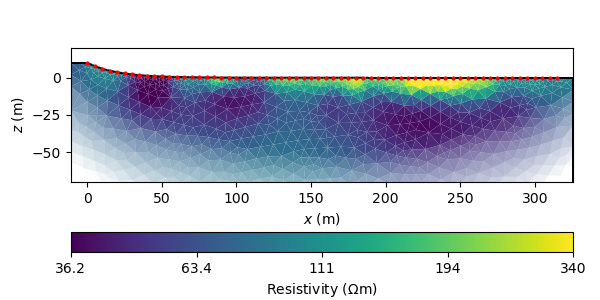

In [27]:
ert.showResult()
fig=plt.gcf()
fig.axes[0].plot(elpos[:,0],elpos[:,2],'ro',ms=2)
fig.axes[0].set(ylim=(-70.0, 20.0))
fig.set_size_inches(6,3);

In [11]:
fig.savefig('houghall2020_res.pdf')

## Show error / misfit

<IPython.core.display.Javascript object>


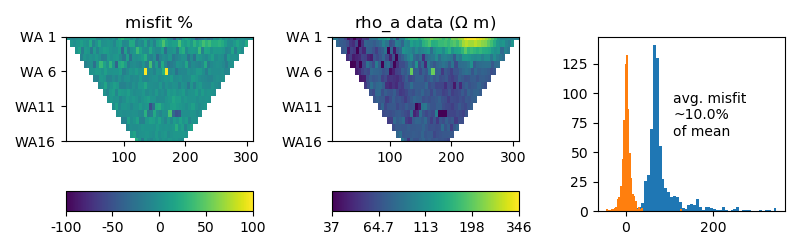

In [23]:
resp=ert.inv.response(); #retrieve the response from the inverted model
diff=np.asarray(readings[:,2])-np.asarray(resp); # compute difference with original data
fig,ax=plt.subplots(1,3,figsize=(8,2.5));
me=round(np.mean(diff),1);
mea=np.mean(np.abs(diff));
mava=max(readings[:,2]);miva=min(readings[:,2]);
miva=37;
#
sd=round(np.std(diff),1);
me2=round(np.mean(readings[:,2]),1);
sd2=round(np.std(readings[:,2]),1);
perc=np.round((mea/me2),1)*100.
sd2=round(np.std(readings[:,2]),1);
#
ert.showData(100*diff/me2,ax=ax[0],cMin=-100,cMax=100,cMap='viridis');
ert.showData(readings[:,2],ax=ax[1],cMin=miva,cMax=mava,cMap='viridis');

ax[0].set_title("misfit %")
ax[1].set_title("rho_a data ($\Omega$ m)")
ax[2].hist(readings[:,2],bins=50);
ax[2].hist(diff,bins=50);
ax[2].text(me2+sd2/2,max(diff)/2,"avg. misfit\n~"+str(perc)+"%\n"+"of mean")

fig.tight_layout()

# END